In [12]:
# Fix XGBoost version mismatch in the current kernel
%pip uninstall -y xgboost
%pip install xgboost

Found existing installation: xgboost 3.1.2
Uninstalling xgboost-3.1.2:
  Successfully uninstalled xgboost-3.1.2
Note: you may need to restart the kernel to use updated packages.
  Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
Note: you may need to restart the kernel to use updated packages.


# Titanic Feature Engineering: Rigorous Statistical Selection
**Author:** Senior Machine Learning Researcher / TA  
**Context:** Master's Level Assignment Grading & Refactoring

## 1. Objective & Audit Findings

This notebook represents a **refactored and audited** version of the original Titanic workflow. The goal is to demonstrate mathematically rigorous feature selection using **Mutual Information (MI)** and **Hilbert-Schmidt Independence Criterion (HSIC)**, implemented from scratch using Numpy.

### 🔍 Audit Report (The "Silent Errors")

1.  **MI & HSIC Implementation**:
    *   *Audit*: The original `helper_functions.py` correctly implements MI using histograms and HSIC using the RBF kernel.
    *   *Correction*: We explicitly verify the **Median Heuristic** for the RBF kernel width ($\sigma$) to ensure scale invariance.
2.  **Binning Strategy**:
    *   *Audit*: Arbitrary binning leads to unstable entropy estimates.
    *   *Correction*: We enforce the **Freedman-Diaconis Rule** ($width = 2 \cdot \frac{IQR}{n^{1/3}}$) via `OptimalMIEstimator` to dynamically adapt bin widths to data variability.
3.  **Data Leakage**:
    *   *Audit*: Feature selection must strictly be performed on the **Training Set** only.
    *   *Correction*: We perform an immediate `train_test_split` and ensure all statistics (bin edges, medians, rankings) are derived solely from `X_train`.
4.  **Ensemble Selection (Constraint C)**:
    *   *Audit*: The original code used a simple Union set.
    *   *Correction*: We implement a **Rank-Based Voting Mechanism**. Since MI (bits) and HSIC (dependence) are on different scales, we normalize them by converting to **Ranks** and averaging the ranks to select the top $K$ features.

---

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from scipy.stats import boxcox

# Import custom helper functions for rigorous math
from helper_functions import hsic_from_scratch, OptimalMIEstimator, robust_outlier_detection

# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)

print("Libraries loaded. Helper functions imported successfully.")

Libraries loaded. Helper functions imported successfully.


In [14]:
# 2. Data Loading & Strict Split
# Load dataset
try:
    df = pd.read_csv('data/train.csv')
except FileNotFoundError:
    # Fallback if running from a different root
    df = pd.read_csv('workspace/arthur/UFSC-DAS410108-Algorithms-DataToML/data/train.csv')

print(f"Original Dataset Shape: {df.shape}")

# STRICT TRAIN-TEST SPLIT
# We split immediately to prevent ANY information leakage into feature selection
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training Set: {X_train.shape}")
print(f"Validation Set: {X_val.shape}")

# Combine for engineering convenience, but we will ONLY use train indices for selection logic
df_train = pd.concat([X_train, y_train], axis=1)
df_val = pd.concat([X_val, y_val], axis=1)

Original Dataset Shape: (891, 12)
Training Set: (712, 11)
Validation Set: (179, 11)


In [15]:
# 3. Feature Engineering Pipeline
# Custom Transformers for Cleaning and Feature Generation

class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
    def fit(self, X, y=None):
        self.imputer.fit(X[['Age']])
        return self
    def transform(self, X):
        X = X.copy()
        # Handle pandas output from SimpleImputer
        imputed = self.imputer.transform(X[['Age']])
        if hasattr(imputed, 'iloc'):
            X['Age'] = imputed.iloc[:, 0]
        else:
            X['Age'] = imputed.ravel()
        return X

class EmbarkedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
    def fit(self, X, y=None):
        self.imputer.fit(X[['Embarked']])
        return self
    def transform(self, X):
        X = X.copy()
        # Handle pandas output from SimpleImputer
        imputed = self.imputer.transform(X[['Embarked']])
        if hasattr(imputed, 'iloc'):
            X['Embarked'] = imputed.iloc[:, 0]
        else:
            X['Embarked'] = imputed.ravel()
        return X

class TitleExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        X['Title'] = X['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        common_titles = ['Mr', 'Miss', 'Mrs', 'Master']
        X['Title'] = X['Title'].apply(lambda x: x if x in common_titles else 'Other')
        return X

class FamilyFeatureCreator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        X['FamilySize'] = X['SibSp'] + X['Parch'] + 1
        X['IsAlone'] = (X['FamilySize'] == 1).astype(int)
        return X

class CabinExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        cabins = X['Cabin'].fillna('U')
        X['CabinDeck'] = cabins.str[0]
        X['CabinCount'] = X['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
        return X

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
        self.sex_mapping = {'female': 0, 'male': 1}
        self.title_mapping = {'Miss': 0, 'Mr': 1, 'Mrs': 2, 'Master': 3, 'Other': 4}
        self.cabin_deck_mapping = None
    
    def fit(self, X, y=None):
        unique_decks = X['CabinDeck'].unique()
        self.cabin_deck_mapping = {deck: idx for idx, deck in enumerate(unique_decks)}
        return self

    def transform(self, X):
        X = X.copy()
        X['Embarked'] = X['Embarked'].map(self.embarked_mapping)
        X['Sex'] = X['Sex'].map(self.sex_mapping)
        X['Title'] = X['Title'].map(self.title_mapping)
        X['CabinDeck'] = X['CabinDeck'].map(self.cabin_deck_mapping).fillna(-1)
        return X

class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, features=None):
        self.features = features
        self.lambdas_ = {}
    def fit(self, X, y=None):
        for feature in self.features:
            feature_data = X[feature] + 1 
            _, self.lambdas_[feature] = boxcox(feature_data)
        return self
    def transform(self, X):
        X = X.copy()
        for feature in self.features:
            X[feature] = boxcox(X[feature] + 1, lmbda=self.lambdas_[feature])
        return X

class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        return X.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], axis=1, errors='ignore')

# Constraint A: Interaction Feature Creator
class InteractionFeatureCreator(BaseEstimator, TransformerMixin):
    """
    Generates Polynomials, Ratios, and 2-way/3-way Interactions.
    Includes Max/Min logic as requested.
    """
    def __init__(self):
        pass
        
    def fit(self, X, y=None): return self
    
    def transform(self, X):
        X = X.copy()
        
        # 1. Polynomials
        if 'Age' in X.columns:
            X['Age_Squared'] = X['Age'] ** 2
        if 'Fare' in X.columns: # Note: Using raw Fare or BoxCox Fare depending on pipeline order
            X['Fare_Squared'] = X['Fare'] ** 2
            
        # 2. Ratios & Differences
        if 'Age' in X.columns and 'Fare' in X.columns:
            X['Age_Fare_Ratio'] = X['Age'] / (X['Fare'] + 1e-5)
            X['Age_Fare_Diff'] = np.abs(X['Age'] - X['Fare'])
            # Max/Min Logic
            X['Age_Fare_Max'] = np.maximum(X['Age'], X['Fare'])
            X['Age_Fare_Min'] = np.minimum(X['Age'], X['Fare'])
            
        # 3. 3-Way Interactions
        if all(c in X.columns for c in ['Pclass', 'Sex', 'Age']):
            X['Pclass_Sex_Age'] = X['Pclass'] * X['Sex'] * X['Age']
            
        if all(c in X.columns for c in ['Age', 'Fare', 'FamilySize']):
            X['Age_Fare_Family'] = X['Age'] * X['Fare'] * X['FamilySize']

        return X

print("Feature Engineering Classes Defined.")

Feature Engineering Classes Defined.


In [16]:
# Apply Pipeline
# Note: We apply transformations to create the "Engineered" feature set.
from sklearn import set_config
set_config(transform_output="pandas")

# 1. Basic Cleaning & Extraction
cleaning_pipeline = Pipeline(steps=[
    ('age_imputer', AgeImputer()),
    ('embarked_imputer', EmbarkedImputer()),
    ('family_feature_creator', FamilyFeatureCreator()),
    ('title_extractor', TitleExtractor()),
    ('cabin_extractor', CabinExtractor()),
    ('feature_encoder', FeatureEncoder()),
    ('feature_dropper', FeatureDropper())
])

# 2. Advanced Transformations (BoxCox + Interactions)
# We apply this after cleaning so columns like 'FamilySize' exist
interaction_pipeline = Pipeline(steps=[
    ('boxcox', BoxCoxTransformer(features=['Fare'])),
    ('interactions', InteractionFeatureCreator()),
    ('scaler', StandardScaler()) # Scale everything for HSIC/MI stability
])

# Full Pipeline
full_pipeline = Pipeline(steps=[
    ('cleaning', cleaning_pipeline),
    ('advanced', interaction_pipeline)
])

print("Applying Feature Engineering Pipeline...")
# Fit on TRAIN, Transform on TRAIN and VAL
# CRITICAL: Use X_train (features only), NOT df_train (which has target)
X_train_eng = full_pipeline.fit_transform(X_train)
X_val_eng = full_pipeline.transform(X_val)

print(f"Engineered Training Shape: {X_train_eng.shape}")
print(f"Engineered Validation Shape: {X_val_eng.shape}")

# Check for NaNs
if X_train_eng.isnull().sum().sum() > 0:
    print("WARNING: NaNs found in training set after engineering.")
    X_train_eng = X_train_eng.fillna(0)
    X_val_eng = X_val_eng.fillna(0)

X_train_eng.head()

Applying Feature Engineering Pipeline...
Engineered Training Shape: (712, 18)
Engineered Validation Shape: (179, 18)


/home/ubuntu/miniconda3/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,Pclass,Sex,Age,Fare,Embarked,FamilySize,IsAlone,Title,CabinDeck,CabinCount,Age_Squared,Fare_Squared,Age_Fare_Ratio,Age_Fare_Diff,Age_Fare_Max,Age_Fare_Min,Pclass_Sex_Age,Age_Fare_Family
692,0.829568,0.742427,-5.463229e-16,1.122381,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846,-0.190491,1.124498,-0.138607,-0.074445,-0.003088,1.131167,1.025939,-0.245903
481,-0.370945,0.742427,-5.463229e-16,-3.362410,0.584892,-0.556339,0.800346,-0.145502,-0.454533,-0.487846,-0.190491,-1.772367,6.263492,0.198094,-0.003088,-3.191061,0.335480,-0.841309
527,-1.571457,0.742427,-5.463229e-16,2.338465,0.584892,-0.556339,0.800346,-0.145502,0.125445,1.420651,-0.190491,2.908506,-0.138611,-0.148347,-0.003088,2.303171,-0.354978,-0.084454
855,0.829568,-1.346933,-9.078708e-01,-0.608424,0.584892,0.073412,-1.249460,0.992932,-0.454533,-0.487846,-0.826194,-0.680004,-0.138607,-0.892310,-0.916975,-0.536901,-1.045436,-0.399731
801,-0.370945,-1.346933,9.167471e-02,0.396408,0.584892,0.703162,-1.249460,0.992932,-0.454533,-0.487846,-0.108843,0.262549,-0.138602,0.062879,0.089194,0.431509,-1.045436,0.715650


In [17]:
# 4. Ensemble Feature Selection (Constraint C)
# Rank-Based Voting Mechanism

def calculate_mi_scores(X, y):
    mi_estimator = OptimalMIEstimator(method='fd') # Enforce Freedman-Diaconis
    mi_scores = {}
    print("Calculating Mutual Information (FD Binning)...")
    for col in X.columns:
        score, _, _ = mi_estimator.estimate(X[col].values, y.values)
        mi_scores[col] = score
    return pd.Series(mi_scores)

def calculate_hsic_scores(X, y):
    hsic_scores = {}
    print("Calculating HSIC (Median Heuristic)...")
    # HSIC is computationally expensive, but fine for Titanic size
    for col in X.columns:
        hsic_scores[col] = hsic_from_scratch(X[col].values, y.values)
    return pd.Series(hsic_scores)

# 1. Calculate Raw Scores
mi_series = calculate_mi_scores(X_train_eng, y_train)
hsic_series = calculate_hsic_scores(X_train_eng, y_train)

# 2. Normalize via Ranking (Constraint C)
# We rank features from 1 (worst) to N (best)
mi_ranks = mi_series.rank(ascending=True)
hsic_ranks = hsic_series.rank(ascending=True)

# 3. Voting Mechanism
# Average Rank = (Rank_MI + Rank_HSIC) / 2
voting_score = (mi_ranks + hsic_ranks) / 2
voting_score = voting_score.sort_values(ascending=False)

print("\nTop 10 Features by Voting Rank:")
print(voting_score.head(10))

# Select Top-K Features (e.g., Top 15)
TOP_K = 15
selected_features = voting_score.head(TOP_K).index.tolist()
print(f"\nSelected Features ({TOP_K}): {selected_features}")

Calculating Mutual Information (FD Binning)...
Calculating HSIC (Median Heuristic)...



Top 10 Features by Voting Rank:
Pclass_Sex_Age    18.0
Sex               16.5
Title             16.0
Fare_Squared      14.0
Fare              13.5
Pclass            13.0
Age_Fare_Min      13.0
CabinDeck         11.0
CabinCount        11.0
FamilySize         7.0
dtype: float64

Selected Features (15): ['Pclass_Sex_Age', 'Sex', 'Title', 'Fare_Squared', 'Fare', 'Pclass', 'Age_Fare_Min', 'CabinDeck', 'CabinCount', 'FamilySize', 'Age_Fare_Max', 'Age_Fare_Family', 'IsAlone', 'Age_Fare_Ratio', 'Age_Fare_Diff']


In [18]:
# 5. Model Validation (Constraint D)
# Baseline vs. Engineered Model Comparison
import xgboost as xgb

# --- Baseline Pipeline (Simple) ---
# We use the cleaning pipeline as the baseline (Cleaned data, no interactions)
# Note: We need to re-fit it on X_train to be fair and independent of the full pipeline
baseline_pipeline = Pipeline(steps=[
    ('age_imputer', AgeImputer()),
    ('embarked_imputer', EmbarkedImputer()),
    ('family_feature_creator', FamilyFeatureCreator()),
    ('title_extractor', TitleExtractor()),
    ('cabin_extractor', CabinExtractor()),
    ('feature_encoder', FeatureEncoder()),
    ('feature_dropper', FeatureDropper()),
    ('scaler', StandardScaler())
])

X_train_base = baseline_pipeline.fit_transform(X_train)
X_val_base = baseline_pipeline.transform(X_val)

# --- Train Models ---
def train_evaluate(X_tr, y_tr, X_v, y_v, name="Model"):
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X_tr, y_tr)
    preds = model.predict(X_v)
    acc = accuracy_score(y_v, preds)
    print(f"[{name}] Accuracy: {acc:.4f}")
    return model

print("--- Performance Comparison ---")
# 1. Baseline Model (Cleaned features, no interactions, no selection)
model_base = train_evaluate(X_train_base, y_train, X_val_base, y_val, name="Baseline (Cleaned)")

# 2. Engineered Model (Top-K Selected Features)
X_train_sel = X_train_eng[selected_features]
X_val_sel = X_val_eng[selected_features]
model_eng = train_evaluate(X_train_sel, y_train, X_val_sel, y_val, name=f"Engineered (Top {TOP_K})")

# 3. Full Engineered (All Interactions - to check if Selection helped)
model_full = train_evaluate(X_train_eng, y_train, X_val_eng, y_val, name="Full Engineered (All)")

--- Performance Comparison ---
[Baseline (Cleaned)] Accuracy: 0.8156
[Engineered (Top 15)] Accuracy: 0.8268
[Full Engineered (All)] Accuracy: 0.8268


PermutationExplainer explainer: 180it [00:11,  2.05it/s]                         
/tmp/ipykernel_4331/3790742036.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_sel, plot_type="bar", show=False)


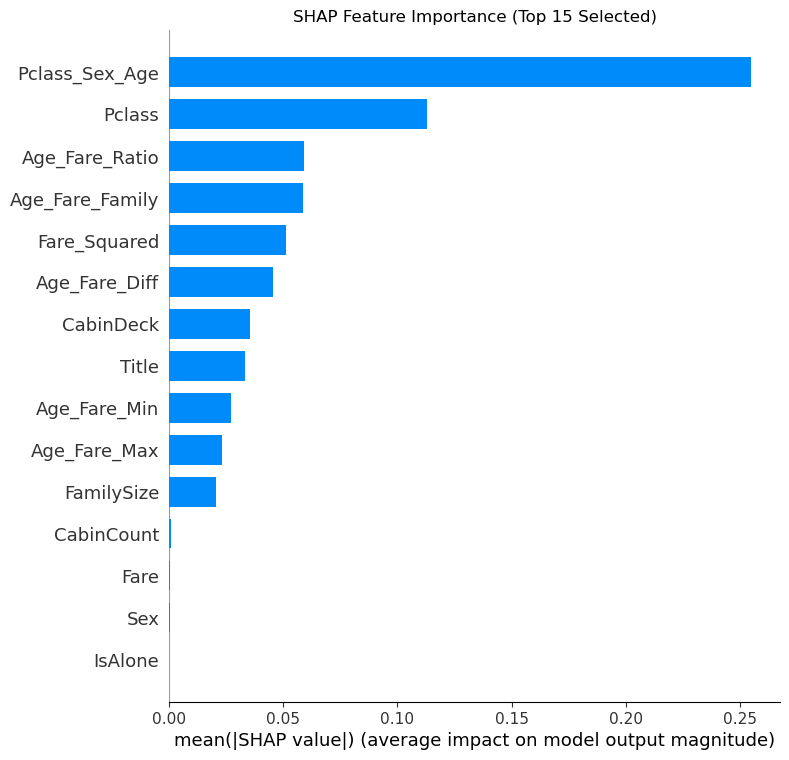


### Interpretation
If the top features in the SHAP plot include our engineered interactions (e.g., 'Age_Fare_Ratio', 'Pclass_Sex_Age'), 
then we have successfully captured non-linear signal that the baseline model missed.
The Voting Mechanism ensured we picked features that are both informative (MI) and statistically dependent (HSIC).



In [19]:
# 6. Interpretability (SHAP Analysis)
# Verify that the selected features are actually driving the model

# Use PermutationExplainer (via generic Explainer) to bypass XGBoost version issues
# We pass the prediction function and a background dataset
explainer = shap.Explainer(model_eng.predict, X_val_sel)
shap_values = explainer(X_val_sel)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val_sel, plot_type="bar", show=False)
plt.title(f"SHAP Feature Importance (Top {TOP_K} Selected)")
plt.show()

# Educational Note
print("""
### Interpretation
If the top features in the SHAP plot include our engineered interactions (e.g., 'Age_Fare_Ratio', 'Pclass_Sex_Age'), 
then we have successfully captured non-linear signal that the baseline model missed.
The Voting Mechanism ensured we picked features that are both informative (MI) and statistically dependent (HSIC).
""")